In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

C:\Users\since\AppData\Local\Temp\ipykernel_21372\2338556962.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect = True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent

('2017-08-23',)

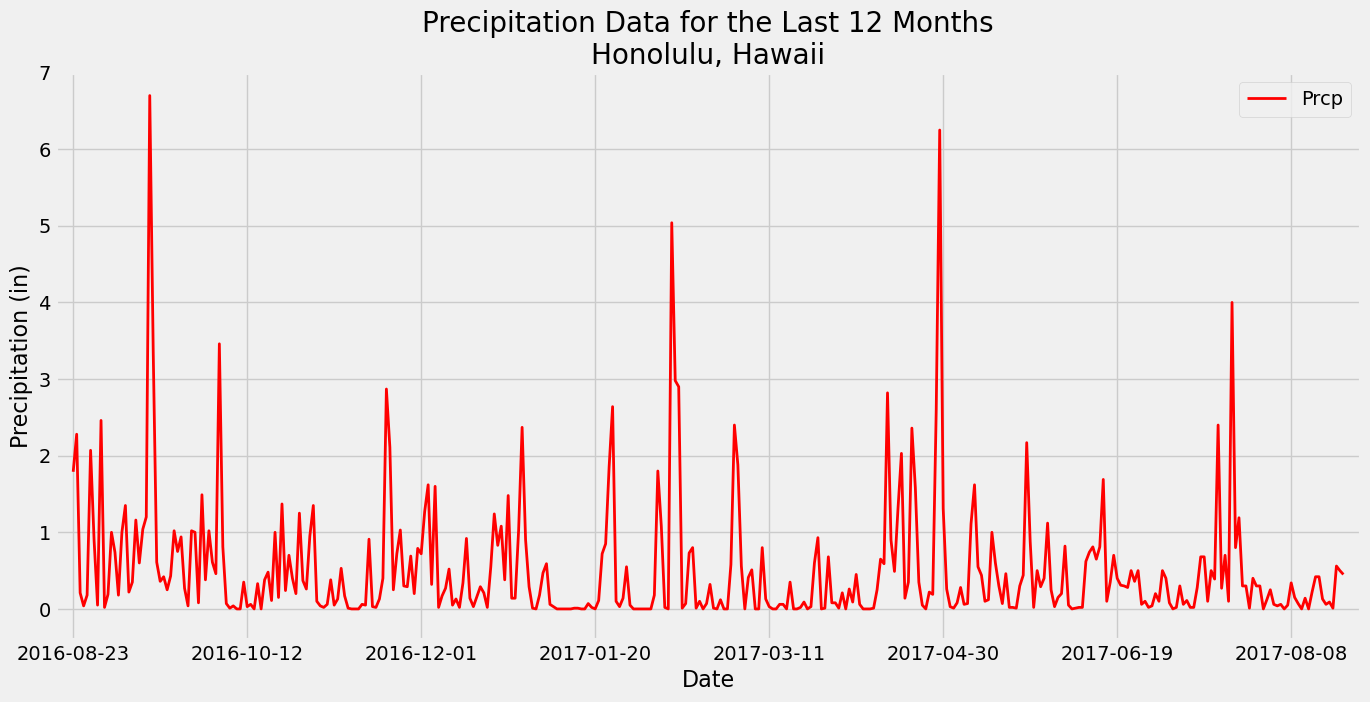

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
prcp_data = (session.query(measurement.date, func.max(measurement.prcp))
             .filter(measurement.date > one_year_ago)
             .group_by(measurement.date)
             .all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'Prcp'])

# Sort the dataframe by date
prcp_df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(15,7)
prcp_df.plot(x='Date', y='Prcp', linewidth=2, alpha=1, rot=0,
             color='r')

plt.xlim(-5, 370)
plt.ylim(-0.4, 7)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.xlabel('Date', fontsize=16, color='black')
plt.ylabel('Precipitation (in)', fontsize=16, color='black')
plt.title('Precipitation Data for the Last 12 Months\nHonolulu, Hawaii', fontsize=20)

plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_stats = (session.query(measurement.date, measurement.prcp)
             .filter(measurement.date>one_year_ago)
             .all())
prcp_stats

#Inputting data into Dataframe
prcp_stats_df = pd.DataFrame(prcp_stats, columns= ['Date', 'Prcp'])
prcp_stats_df
prcp_stats_df.dropna()

#Summary Statistics for Data
prcp_stats_df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station).count()
print(f"There are {total_stations} stations in total")

There are 9 stations in total


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = (session.query(measurement.station,func.count(measurement.station))
                    .group_by(measurement.station)
                    .order_by(func.count(measurement.station).desc())
                    .all())
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = [measurement.station,
             func.min(measurement.tobs),
             func.max(measurement.tobs),
             func.avg(measurement.tobs)]
active_station = (session.query(*temps)
                      .filter(measurement.station=='USC00519281').\
                      all())
active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

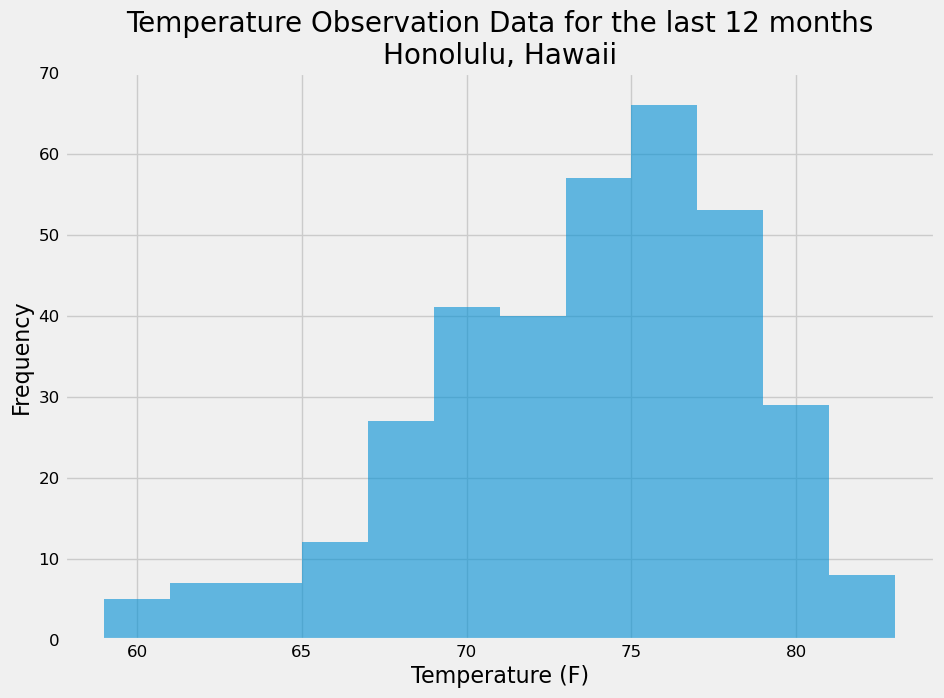

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps = (session.query(measurement.date,(measurement.tobs))
              .filter(func.strftime(measurement.date) > one_year_ago)
              .filter(measurement.station=='USC00519281')
              .all())

temps_df = pd.DataFrame(year_temps)
temps_df.set_index('date',inplace=True)

plt.rcParams['figure.figsize']=(10,7)
plt.hist(temps_df['tobs'],bins=12,alpha=0.6,linewidth=1)

plt.title('Temperature Observation Data for the last 12 months\nHonolulu, Hawaii',fontsize=20)
plt.xlabel('Temperature (F)',fontsize=16,color='black')
plt.ylabel('Frequency',fontsize=16,color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)

plt.show()

# Close Session

In [18]:
# Close Session
session.close()